In [1]:
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


Rendering animation to MP4. This may take a minute or two depending on runtime...

=== New Cycle 1 ===
Vehicle counts: {'North': 5, 'East': 0, 'South': 0, 'West': 5}
Green times: {'North': 8, 'East': 6, 'South': 6, 'West': 8}
Starting green: North for 8 s

=== New Cycle 2 ===
Vehicle counts: {'North': 6, 'East': 2, 'South': 0, 'West': 0}
Green times: {'North': 9, 'East': 7, 'South': 6, 'West': 6}
Starting green: North for 9 s

=== New Cycle 3 ===
Vehicle counts: {'North': 6, 'East': 1, 'South': 6, 'West': 0}
Green times: {'North': 9, 'East': 6, 'South': 9, 'West': 6}
Starting green: North for 9 s

=== New Cycle 4 ===
Vehicle counts: {'North': 3, 'East': 3, 'South': 5, 'West': 3}
Pedestrian request active.
Green times: {'North': 7, 'East': 7, 'South': 8, 'West': 7}
Starting green: North for 7 s
Saved video to: /content/adaptive_traffic_simulation.mp4

=== New Cycle 5 ===
Vehicle counts: {'North': 1, 'East': 3, 'South': 0, 'West': 5}
Green times: {'North': 6, 'East': 7, 'South': 6, 'West

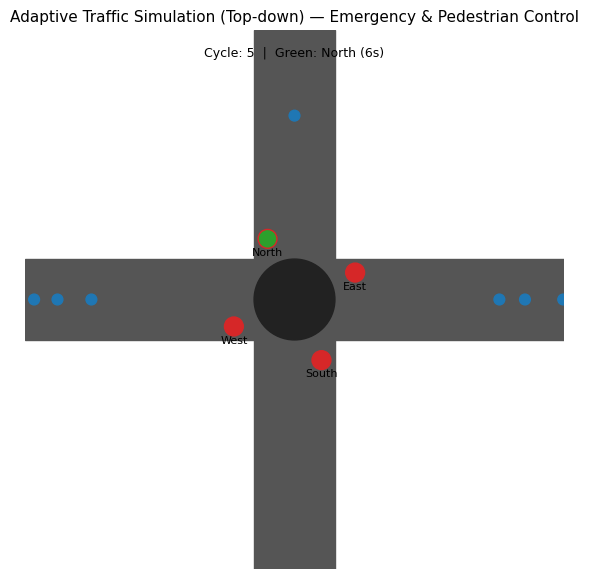

In [2]:
# Adaptive Traffic Signal Simulation with Emergency & Pedestrian Control
# Author: Tonny Talukder

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import matplotlib.patches as patches
import os

# --------------------- User-configurable parameters ---------------------
# Total simulated seconds and frame timing
SIM_SECONDS = 30          # total virtual simulation time (seconds)
DT = 0.2                  # simulation timestep (seconds per frame)
FPS = int(1/DT) if DT>0 else 20
FRAMES = int(SIM_SECONDS / DT)

# Visual / physical parameters
LANE_DIST = 6.0           # spawn distance from intersection center
INTERSECTION_RADIUS = 1.2
ROAD_WIDTH = 2.4
CAR_SPEED = 2.5           # base speed (units/second)

# Logic parameters
BASE_GREEN = 6            # base green time (seconds)
PEDESTRIAN_CROSS_TIME = 5 # pedestrian crossing duration (seconds)
EMERGENCY_PROB = 0.10     # per-cycle probability of an emergency (0.0 - 1.0)
PEDESTRIAN_PROB = 0.15    # per-cycle probability of a pedestrian request
SEED = 42                 # set a seed for reproducible demonstration

# Output
OUT_FILENAME = "adaptive_traffic_simulation.mp4"
OUT_PATH = "/content/" + OUT_FILENAME  # in Colab use /content/

# --------------------------- Internal setup --------------------------------
random.seed(SEED)
np.random.seed(SEED)

DIRECTIONS = ["North", "East", "South", "West"]
DIR_ANGLE = {"North": 90, "East": 0, "South": 270, "West": 180}

# Colors for lights and cars
LIGHT_COLORS = {"red": "#d62728", "yellow": "#ff7f0e", "green": "#2ca02c"}
CAR_COLOR = "#1f77b4"
EMER_COLOR = "gold"

# --------------------------- Helper functions -------------------------------
def generate_vehicle_counts():
    """
    Simulate an incoming vehicle count per direction.
    Counts are integers between 0 and 6 (adjustable inside function).
    """
    return {d: random.randint(0, 6) for d in DIRECTIONS}

def calc_green_times(vehicle_counts):
    """
    Adaptive green time calculation:
    - Base green + 1 second for every 2 vehicles (integer division).
    This makes busier lanes have longer green time.
    """
    return {d: BASE_GREEN + (vehicle_counts[d] // 2) for d in DIRECTIONS}

def detect_emergency():
    """
    Randomly determine whether an emergency vehicle appears this cycle.
    Returns the direction string if an emergency is present; otherwise None.
    """
    if random.random() < EMERGENCY_PROB:
        return random.choice(DIRECTIONS)
    return None

def pedestrian_request():
    """
    Randomly determine whether a pedestrian presses the crossing button this cycle.
    Returns True/False.
    """
    return random.random() < PEDESTRIAN_PROB

def spawn_cars(vehicle_counts):
    """
    Create a list of car objects given vehicle counts.
    Each car is a dict with position, direction, speed and emergency flag.
    Cars spawn on their lane at increasing offsets so they are visually separate.
    """
    new = []
    for d, cnt in vehicle_counts.items():
        angle_deg = DIR_ANGLE[d]
        angle_rad = math.radians(angle_deg)
        for i in range(cnt):
            offset = i * 1.0 + random.uniform(-0.2, 0.2)
            sx = math.cos(angle_rad) * (LANE_DIST + offset)
            sy = math.sin(angle_rad) * (LANE_DIST + offset)
            speed = CAR_SPEED * random.uniform(0.85, 1.15)
            new.append({
                "pos": np.array([sx, sy], dtype=float),
                "dir": d,
                "speed": speed,
                "is_emergency": False
            })
    return new

# --------------------------- Matplotlib setup -------------------------------
fig, ax = plt.subplots(figsize=(7,7))
ax.set_xlim(-LANE_DIST-2, LANE_DIST+2)
ax.set_ylim(-LANE_DIST-2, LANE_DIST+2)
ax.set_aspect('equal')
ax.axis('off')
ax.set_title("Adaptive Traffic Simulation (Top-down) — Emergency & Pedestrian Control", fontsize=11)

# Draw roads (simple rectangles)
ax.add_patch(patches.Rectangle((-LANE_DIST-2, -ROAD_WIDTH/2), 2*(LANE_DIST+2), ROAD_WIDTH, color="#555555"))
ax.add_patch(patches.Rectangle((-ROAD_WIDTH/2, -LANE_DIST-2), ROAD_WIDTH, 2*(LANE_DIST+2), color="#555555"))

# Intersection visual
ax.add_patch(patches.Circle((0,0), INTERSECTION_RADIUS, color="#222222", zorder=3))

# Light positions for small circles indicating each direction's signal
light_positions = {
    "North": (-0.8, INTERSECTION_RADIUS + 0.6),
    "East":  (INTERSECTION_RADIUS + 0.6, 0.8),
    "South": (0.8, -INTERSECTION_RADIUS - 0.6),
    "West":  (-INTERSECTION_RADIUS - 0.6, -0.8)
}
light_artists = {}
for d, (lx, ly) in light_positions.items():
    c = patches.Circle((lx, ly), 0.28, color=LIGHT_COLORS["red"], zorder=4)
    ax.add_patch(c)
    light_artists[d] = c
    ax.text(lx, ly-0.5, d, fontsize=8, ha='center')

# Scatter for cars and emergency cars (emergency cars drawn with different marker size/color)
car_scatter = ax.scatter([], [], s=50, zorder=5)
em_scatter = ax.scatter([], [], s=140, marker='*', edgecolors='yellow', linewidths=1.2, zorder=6)

# Status texts
status_text = ax.text(0, LANE_DIST + 1.2, "", ha='center', fontsize=9)
ped_text = ax.text(0, -LANE_DIST - 1.6, "", ha='center', fontsize=9, color='crimson')

# --------------------------- Simulation state -------------------------------
state = {
    "frame": 0,
    "cycle": 0,
    "cars": [],
    "vehicle_counts": {d:0 for d in DIRECTIONS},
    "green_times": {d:BASE_GREEN for d in DIRECTIONS},
    "current_green": "North",
    "green_remaining": float(BASE_GREEN),
    "emergency_dir": None,
    "pedestrian_active": False,
    "ped_remaining": 0.0
}

def initialize_cycle():
    """
    Start a new cycle:
      - generate vehicle counts
      - compute green times
      - detect emergency and pedestrian request
      - spawn cars
      - assign starting green (emergency gets immediate green)
    """
    state["cycle"] += 1
    vc = generate_vehicle_counts()
    state["vehicle_counts"] = vc
    state["green_times"] = calc_green_times(vc)
    em = detect_emergency()
    state["emergency_dir"] = em
    ped = pedestrian_request()
    state["pedestrian_active"] = ped
    state["ped_remaining"] = PEDESTRIAN_CROSS_TIME if ped else 0.0
    spawned = spawn_cars(vc)
    # If an emergency exists, mark one car in that lane as emergency for visual
    if em:
        for c in spawned:
            if c["dir"] == em:
                c["is_emergency"] = True
                break
    state["cars"] = spawned
    # Assign starting green: emergency gets priority otherwise default to North
    if em:
        state["current_green"] = em
        # add a few extra seconds to ensure emergency passes
        state["green_remaining"] = state["green_times"][em] + 4
    else:
        state["current_green"] = "North"
        state["green_remaining"] = state["green_times"][state["current_green"]]

    # Print summary for debug / demo in Colab output
    print(f"\n=== New Cycle {state['cycle']} ===")
    print("Vehicle counts:", state["vehicle_counts"])
    if em:
        print("Emergency detected at:", em)
    if ped:
        print("Pedestrian request active.")
    print("Green times:", state["green_times"])
    print("Starting green:", state["current_green"], "for", int(state["green_remaining"]), "s")

def update_cars(dt):
    """
    Move cars toward the intersection.
    - If their lane has current green and no pedestrian crossing, they move faster.
    - Otherwise they approach slowly / wait.
    - When a car reaches very near the center it is removed (simulating passing the intersection).
    """
    new_list = []
    for car in state["cars"]:
        dir_vec = -car["pos"]   # vector from car to origin (intersection)
        dist = np.linalg.norm(dir_vec)
        if dist < 0.6:
            # car has passed the intersection -> remove
            continue
        unit = dir_vec / (dist + 1e-9)
        allowed = (state["current_green"] == car["dir"] and state["ped_remaining"] <= 0)
        # Emergency cars get priority (if emergency_dir matches)
        if car.get("is_emergency", False) and state["emergency_dir"] == car["dir"]:
            allowed = True
        speed_factor = 1.2 if allowed else 0.15
        car["pos"] += unit * car["speed"] * speed_factor * dt
        new_list.append(car)
    state["cars"] = new_list

def update_lights_and_timers(dt):
    """
    Update the green timer and manage rotation of the green light.
    If an emergency is active, serve it first and then clear emergency.
    When green time expires, rotate clockwise to next direction.
    Pedestrian crossing overrides vehicle greens while active.
    """
    # timers
    if state["green_remaining"] > 0:
        state["green_remaining"] -= dt
    if state["ped_remaining"] > 0:
        state["ped_remaining"] -= dt
        if state["ped_remaining"] < 0:
            state["ped_remaining"] = 0.0

    # If green time is up, rotate to next lane (and clear emergency if it was being served)
    if state["green_remaining"] <= 0:
        if state["emergency_dir"]:
            # emergency was served: clear it and rotate to the next direction
            state["emergency_dir"] = None
            idx = DIRECTIONS.index(state["current_green"])
            next_idx = (idx + 1) % len(DIRECTIONS)
            state["current_green"] = DIRECTIONS[next_idx]
            state["green_remaining"] = state["green_times"][state["current_green"]]
        else:
            # normal rotation
            idx = DIRECTIONS.index(state["current_green"])
            next_idx = (idx + 1) % len(DIRECTIONS)
            state["current_green"] = DIRECTIONS[next_idx]
            state["green_remaining"] = state["green_times"][state["current_green"]]

def draw_frame(frame):
    """
    Main update called by FuncAnimation for each frame.
    - Initializes new cycle when needed
    - Updates car positions, lights, and text
    - Returns artists that changed
    """
    dt = DT
    state["frame"] = frame

    # If no active cars (previous cycle finished) or first frame -> start new cycle
    if frame == 0 or len(state["cars"]) == 0:
        initialize_cycle()

    # Update simulation elements
    update_cars(dt)
    update_lights_and_timers(dt)

    # Prepare scatter data
    xs = [c["pos"][0] for c in state["cars"]]
    ys = [c["pos"][1] for c in state["cars"]]
    sizes = [120 if c.get("is_emergency", False) else 60 for c in state["cars"]]
    colors = [EMER_COLOR if c.get("is_emergency", False) else CAR_COLOR for c in state["cars"]]

    if len(xs) > 0:
        car_scatter.set_offsets(np.c_[xs, ys])
        car_scatter.set_sizes(sizes)
        car_scatter.set_color(colors)
    else:
        car_scatter.set_offsets(np.empty((0,2)))
        car_scatter.set_sizes([])

    # Emergency star marker
    em_xs = [c["pos"][0] for c in state["cars"] if c.get("is_emergency", False)]
    em_ys = [c["pos"][1] for c in state["cars"] if c.get("is_emergency", False)]
    if len(em_xs) > 0:
        em_scatter.set_offsets(np.c_[em_xs, em_ys])
    else:
        em_scatter.set_offsets(np.empty((0,2)))

    # Update light visuals
    for d, art in light_artists.items():
        # If pedestrian crossing is active, show all red for vehicles
        if state["ped_remaining"] > 0:
            art.set_facecolor(LIGHT_COLORS["red"])
        else:
            art.set_facecolor(LIGHT_COLORS["green"] if state["current_green"] == d else LIGHT_COLORS["red"])

    # Pedestrian text
    if state["ped_remaining"] > 0:
        ped_text.set_text(f"PEDESTRIAN CROSSING ACTIVE ({int(math.ceil(state['ped_remaining']))}s)")
    else:
        ped_text.set_text("")

    # Status text
    status = f"Cycle: {state['cycle']}  |  Green: {state['current_green']} ({max(0,int(math.ceil(state['green_remaining'])))}s)"
    status_text.set_text(status)

    # Return modified artists
    artists = [car_scatter, em_scatter] + list(light_artists.values()) + [status_text, ped_text]
    return artists

# --------------------------- Create and save animation ----------------------
anim = FuncAnimation(fig, draw_frame, frames=FRAMES, interval=1000*DT, blit=False)

# Ensure ffmpeg is available in Colab. If not present, run: !apt-get install -y ffmpeg
writer = FFMpegWriter(fps=FPS)

print("Rendering animation to MP4. This may take a minute or two depending on runtime...")
anim.save(OUT_PATH, writer=writer, dpi=150)
print("Saved video to:", OUT_PATH)

# If running locally (not Colab), you can change OUT_PATH to a local folder.
